In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize, RobustScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

seed = 33

### Reading data

In [2]:
df = pd.read_csv('dataset/winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Studying data

In [3]:
# Check null values
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [4]:
# View features description
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000
mean,6.854736,0.278258,0.334182,6.390437,0.045767,35.305777,138.349765,0.994026,3.188312,0.489871,10.514652,5.878547
std,0.843790,0.100791,0.121009,5.072002,0.021849,17.006169,42.500564,0.002991,0.151018,0.114127,1.230790,0.886671
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991720,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       6
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

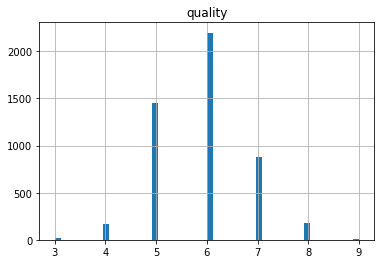

In [6]:
df.hist(column='quality', bins=50)

In [7]:
def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return out

In [8]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(df[name])
    count += len(outliers)
print('Total: ', count)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
Total:  1063


<AxesSubplot:>

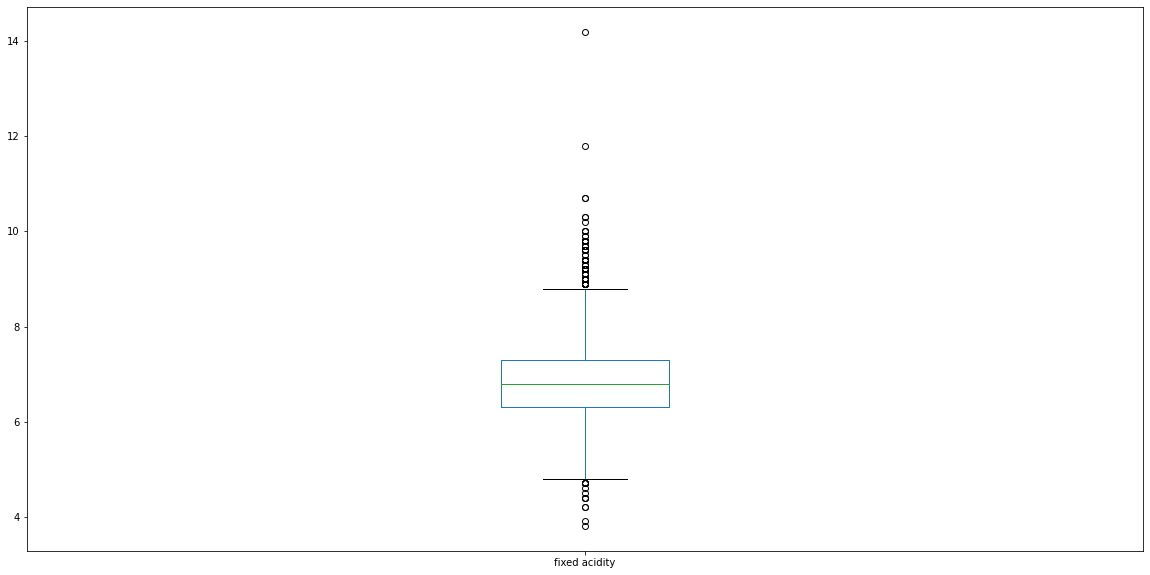

In [9]:
fig = plt.figure(figsize = (20,10))
df.boxplot(column=['fixed acidity'], grid=False)

#### Detect features and target

In [10]:
bins = (1, 4.5, 7.5, 10)
group_names = ['bad', 'good', 'high']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [11]:
df['quality'].value_counts()

good    4535
bad      183
high     181
Name: quality, dtype: int64

In [12]:
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

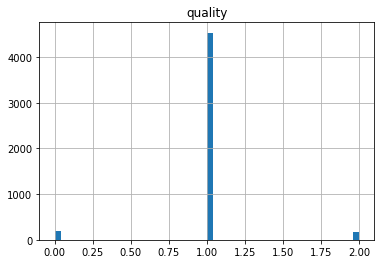

In [13]:
df.hist(column='quality', bins=50)

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(X.shape)
print(y.shape)

(4899, 11)
(4899,)


#### Preprocessing

In [15]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

(12391, 11)
(12391,)


<AxesSubplot:>

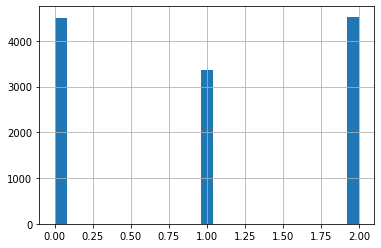

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Balance dataset
over = SMOTEENN()

X, y = over.fit_resample(X, y)
print(X.shape)
print(y.shape)
y.hist(bins=25)

In [17]:
balanced_scaled_df = pd.DataFrame(X, columns = [name for name in list(df.iloc[:, :-1])])

In [18]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(balanced_scaled_df[name])
    count += len(outliers)
print('Total: ', count)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
Total:  3621


### Feature selection 

#### By correlation 

<AxesSubplot:>

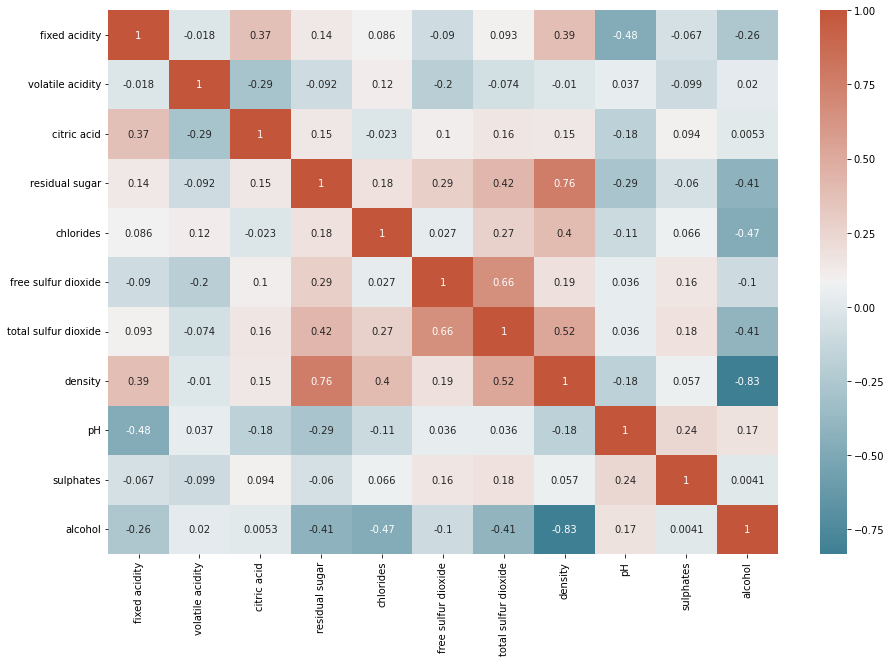

In [19]:
corr = balanced_scaled_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [20]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if abs(corr.iloc[i, j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = balanced_scaled_df.columns[columns]
print(selected_columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates'],
      dtype='object')


In [21]:
reduced_df = balanced_scaled_df[selected_columns]

In [22]:
reduced_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,-0.6,1.727273,-0.500000,-0.097561,1.428571,1.260870,1.220339,0.059361,0.473684,0.357143
1,3.0,0.909091,1.166667,0.646341,-0.357143,-1.304348,-0.864407,0.424658,-1.526316,-1.214286
2,-1.3,2.045455,-2.666667,-0.451220,1.571429,-1.130435,-0.525424,0.059361,2.368421,-0.500000
3,-0.4,3.045455,-1.500000,0.000000,1.071429,-0.826087,-0.627119,0.310502,1.052632,-0.785714
4,0.8,2.000000,0.416667,-0.536585,-0.428571,-1.304348,-0.576271,-0.808219,-0.789474,-0.571429


In [23]:
X = reduced_df.iloc[:, :].values
print(X.shape)

(12391, 10)


#### Split data in train and test 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [6]:
X_test[:5]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
2058,7.3,0.29,0.37,8.3,0.044,45.0,227.0,0.99660,3.12,0.47,9.0
1760,6.4,0.28,0.19,5.4,0.042,67.0,181.0,0.99435,3.31,0.35,10.2
2971,7.3,0.26,0.24,1.7,0.050,10.0,112.0,0.99286,3.11,0.43,9.9
2027,6.9,0.32,0.15,8.1,0.046,51.0,180.0,0.99580,3.13,0.45,8.9
374,5.1,0.33,0.22,1.6,0.027,18.0,89.0,0.98930,3.51,0.38,12.5


In [7]:
y_test[:5]

2058    5
1760    6
2971    5
2027    5
374     7
Name: quality, dtype: int64

In [8]:
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (3919, 11) (3919,)
Test set: (980, 11) (980,)


#### Util functions 

In [9]:
def print_cros_val_score(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
    scores = cross_val_score(model, X, y, cv=5, n_jobs = -1)
    print(scores.mean())

In [10]:
all_metrics = {}
def print_metrics(y_pred, model_name=''):

    confusion_mat = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion matrix is : ", confusion_mat)
    
    acc =  metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    print("Recall_score is :", recall)
    
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    print("Precision Score is : ", precision)
    
    f1 = 2 * (recall * precision) / (recall + precision)
    print("F1 score is: ", f1)
    
    jacc = metrics.jaccard_score(y_test, y_pred, average='weighted')
    print("Jaccard: ", jacc)
    
    all_metrics[model_name] = {}
    all_metrics[model_name]['Accuracy'] = acc
    all_metrics[model_name]['Recall_score'] = recall
    all_metrics[model_name]['Precision'] = precision
    all_metrics[model_name]['F1'] = f1
    all_metrics[model_name]['Jaccard'] = jacc
    
    

In [11]:
test_cases = X_test[:3]
expected = [0, 1, 0]

def test_prediction(model):
    y_prediction_test = model.predict(test_cases)
    print("Predicted: ", y_prediction_test)
    print("Expected: ", expected)

In [12]:
def get_best_params(model, param):
    grid_svc = GridSearchCV(model, param_grid=param, scoring='accuracy', cv=10)
    grid_svc.fit(X_train, y_train)
    best = grid_svc.best_params_
    return best

# K nearest neighbor (KNN)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
param = {
    'n_neighbors': [1, 2, 5, 8, 12, 20, 50],
}
get_best_params(KNeighborsClassifier(), param)

{'n_neighbors': 1}

In [13]:
from sklearn.neighbors import KNeighborsClassifier
k = 1
neigh = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

In [36]:
print_cros_val_score(neigh)

0.9698173942798279


In [14]:
y_pred = neigh.predict(X_test)

In [15]:
print_metrics(y_pred, 'KNN')

Confusion matrix is :  [[  1   0   0   2   0   0   0]
 [  3   7  10  12   3   0   0]
 [  4  12 178  80  16   3   1]
 [  0  12  62 303  54  10   0]
 [  0   3  13  55  90   6   0]
 [  0   1   2  21   5  10   0]
 [  0   0   0   1   0   0   0]]
Accuracy: 0.6010204081632653
Recall_score is : 0.6010204081632653
Precision Score is :  0.6017059899495028
F1 score is:  0.6013630036576689
Jaccard:  0.4366862567328701


In [86]:
test_prediction(neigh)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# SVM

In [40]:
from sklearn.svm import SVC

param = {
    'C': [1, 1.2],
    'gamma' :[0.9, 1.2]
}
get_best_params(SVC(), param)

{'C': 1.2, 'gamma': 1.2}

In [16]:
from sklearn.svm import SVC

svc = SVC(C=1.2, gamma=1.2, kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=1.2, gamma=1.2)

In [42]:
print_cros_val_score(svc)

0.9924951188042511


In [17]:
y_pred = svc.predict(X_test)

In [18]:
print_metrics(y_pred, 'SVC')

Confusion matrix is :  [[  0   0   0   3   0   0   0]
 [  0   5   0  30   0   0   0]
 [  0   0  94 200   0   0   0]
 [  0   0   6 434   1   0   0]
 [  0   0   1 109  57   0   0]
 [  0   0   0  30   1   8   0]
 [  0   0   0   1   0   0   0]]
Accuracy: 0.610204081632653
Recall_score is : 0.610204081632653
Precision Score is :  0.7613571751759574
F1 score is:  0.6774517048603169
Jaccard:  0.4043542463297128


/mnt/d/packages/anaconda3/envs/si/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
test_prediction(svc)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


In [47]:
from sklearn.svm import NuSVC

param = {
    'nu': [0.2, 0.5, 0.8],
    'gamma' :[0.1, 1, 1.5]
}
get_best_params(NuSVC(), param)

{'gamma': 1.5, 'nu': 0.2}

In [19]:
from sklearn.svm import NuSVC

nuSvc = NuSVC(gamma=1.5, nu=0.2)
nuSvc.fit(X_train, y_train)

ValueError: specified nu is infeasible

In [49]:
print_cros_val_score(nuSvc)

0.9919300168225036


In [20]:
y_pred = nuSvc.predict(X_test)

AttributeError: 'NuSVC' object has no attribute 'support_vectors_'

In [21]:
print_metrics(y_pred, 'NuSVC')

Confusion matrix is :  [[  0   0   0   3   0   0   0]
 [  0   5   0  30   0   0   0]
 [  0   0  94 200   0   0   0]
 [  0   0   6 434   1   0   0]
 [  0   0   1 109  57   0   0]
 [  0   0   0  30   1   8   0]
 [  0   0   0   1   0   0   0]]
Accuracy: 0.610204081632653
Recall_score is : 0.610204081632653
Precision Score is :  0.7613571751759574
F1 score is:  0.6774517048603169
Jaccard:  0.4043542463297128


/mnt/d/packages/anaconda3/envs/si/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
test_prediction(nuSvc)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# Bagging

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(RandomForestClassifier(), param)

{'max_features': 'sqrt', 'n_estimators': 200}

In [22]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 200
max_features = 'sqrt'
rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [55]:
print_cros_val_score(rf)

0.9659430418094723


In [23]:
y_pred = rf.predict(X_test)

In [24]:
print_metrics(y_pred, 'RandomForestClassifier')

Confusion matrix is :  [[  0   0   0   3   0   0   0]
 [  0   7  18  10   0   0   0]
 [  0   3 204  87   0   0   0]
 [  0   0  55 361  24   1   0]
 [  0   0   2  74  89   2   0]
 [  0   0   1  16  13   9   0]
 [  0   0   1   0   0   0   0]]
Accuracy: 0.6836734693877551
Recall_score is : 0.6836734693877551
Precision Score is :  0.6878357901663316
F1 score is:  0.6857483137736539
Jaccard:  0.5118594452429844


/mnt/d/packages/anaconda3/envs/si/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
test_prediction(rf)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


## Extra Trees 

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(ExtraTreesClassifier(), param)

{'max_features': 'log2', 'n_estimators': 200}

In [25]:
from sklearn.ensemble import ExtraTreesClassifier


n_estimators = 200
max_features = 'log2'
et = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features, random_state=seed)
et.fit(X_train, y_train)

ExtraTreesClassifier(max_features='log2', n_estimators=200, random_state=33)

In [61]:
print_cros_val_score(et)

0.9763538175883231


In [26]:
y_pred = et.predict(X_test)

In [27]:
print_metrics(y_pred, 'ExtraTreesClassifier')

Confusion matrix is :  [[  0   0   2   1   0   0   0]
 [  1   8  19   7   0   0   0]
 [  0   5 204  85   0   0   0]
 [  0   2  43 371  24   1   0]
 [  0   0   2  79  84   2   0]
 [  0   0   0  16  13  10   0]
 [  0   0   1   0   0   0   0]]
Accuracy: 0.6908163265306122
Recall_score is : 0.6908163265306122
Precision Score is :  0.6924483226101672
F1 score is:  0.6916313618438408
Jaccard:  0.5213963965033922


/mnt/d/packages/anaconda3/envs/si/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
test_prediction(et)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# Boosting

## AdaBoost 

In [67]:
from sklearn.ensemble import AdaBoostClassifier


param = {
    'n_estimators': [50, 100, 200, 500],
}
get_best_params(AdaBoostClassifier(), param)

{'n_estimators': 200}

In [28]:
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 500
ab = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=7)

In [71]:
print_cros_val_score(ab)

0.7810511932191668


In [29]:
y_pred = ab.predict(X_test)

In [30]:
print_metrics(y_pred, 'AdaBoostClassifier')

Confusion matrix is :  [[  1   0   0   2   0   0   0]
 [ 14   0   0  21   0   0   0]
 [ 30   3  15 244   2   0   0]
 [ 23   3  32 355  27   0   1]
 [  2   1   9 130  24   0   1]
 [  2   0   0  24  12   0   1]
 [  0   0   0   1   0   0   0]]
Accuracy: 0.4030612244897959
Recall_score is : 0.4030612244897959
Precision Score is :  0.34891805266805265
F1 score is:  0.3740404604938588
Jaccard:  0.21824676520857098


/mnt/d/packages/anaconda3/envs/si/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
test_prediction(ab)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier


param = {
    'n_estimators': [100, 500],
    'learning_rate': [0.1, 0.4, 0.7],
    'max_features' :['sqrt', 'log2', None],
}
get_best_params(GradientBoostingClassifier(), param)

{'learning_rate': 0.7, 'max_features': 'log2', 'n_estimators': 500}

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators=500
learning_rate=0.7
max_features='log2'
gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_features=max_features, random_state=seed)
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7, max_features='log2',
                           n_estimators=500, random_state=33)

In [78]:
print_cros_val_score(gb)

0.9708670833386239


In [32]:
y_pred = gb.predict(X_test)

In [33]:
print_metrics(y_pred, 'GradientBoostingClassifier')

Confusion matrix is :  [[  0   1   0   2   0   0   0]
 [  0   1   2   1  20  11   0]
 [  1   3   9  46 198  36   1]
 [  0   3  12 146 190  77  13]
 [  0   0   4  75  33  45  10]
 [  0   0   0  21   3   9   6]
 [  0   0   0   1   0   0   0]]
Accuracy: 0.20204081632653062
Recall_score is : 0.20204081632653062
Precision Score is :  0.34414191048420584
F1 score is:  0.2546060470729409
Jaccard:  0.13288035344681245


In [34]:
test_prediction(gb)

Predicted:  [7 5 7]
Expected:  [0, 1, 0]


In [40]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df['Best'] = metrics_df.idxmax(axis=1)
metrics_df

,KNN,SVC,NuSVC,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,Best
Accuracy,0.601020,0.610204,0.610204,0.683673,0.690816,0.403061,0.202041,ExtraTreesClassifier
Recall_score,0.601020,0.610204,0.610204,0.683673,0.690816,0.403061,0.202041,ExtraTreesClassifier
Precision,0.601706,0.761357,0.761357,0.687836,0.692448,0.348918,0.344142,SVC
F1,0.601363,0.677452,0.677452,0.685748,0.691631,0.374040,0.254606,ExtraTreesClassifier
Jaccard,0.436686,0.404354,0.404354,0.511859,0.521396,0.218247,0.132880,ExtraTreesClassifier
